Lambda School Data Science

*Unit 2, Sprint 3, Module 3*

---


# Permutation & Boosting

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] If you haven't completed assignment #1, please do so first.
- [ ] Continue to clean and explore your data. Make exploratory visualizations.
- [ ] Fit a model. Does it beat your baseline? 
- [ ] Try xgboost.
- [ ] Get your model's permutation importances.

You should try to complete an initial model today, because the rest of the week, we're making model interpretation visualizations.

But, if you aren't ready to try xgboost and permutation importances with your dataset today, that's okay. You can practice with another dataset instead. You may choose any dataset you've worked with previously.

The data subdirectory includes the Titanic dataset for classification and the NYC apartments dataset for regression. You may want to choose one of these datasets, because example solutions will be available for each.


## Reading

Top recommendations in _**bold italic:**_

#### Permutation Importances
- _**[Kaggle / Dan Becker: Machine Learning Explainability](https://www.kaggle.com/dansbecker/permutation-importance)**_
- [Christoph Molnar: Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/feature-importance.html)

#### (Default) Feature Importances
  - [Ando Saabas: Selecting good features, Part 3, Random Forests](https://blog.datadive.net/selecting-good-features-part-iii-random-forests/)
  - [Terence Parr, et al: Beware Default Random Forest Importances](https://explained.ai/rf-importance/index.html)

#### Gradient Boosting
  - [A Gentle Introduction to the Gradient Boosting Algorithm for Machine Learning](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/)
  - [An Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/ISLR%20Seventh%20Printing.pdf), Chapter 8
  - _**[Gradient Boosting Explained](https://www.gormanalysis.com/blog/gradient-boosting-explained/)**_ — Ben Gorman
  - [Gradient Boosting Explained](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html) — Alex Rogozhnikov
  - [How to explain gradient boosting](https://explained.ai/gradient-boosting/) — Terence Parr & Jeremy Howard

In [170]:
#library versions
!pip install -U scikit-learn
!python -m pip show scikit-learn


Requirement already up-to-date: scikit-learn in /Users/johnrivera/.virtualenvs/jupyter/lib/python3.7/site-packages (0.23.1)
Name: scikit-learn
Version: 0.23.1
Summary: A set of python modules for machine learning and data mining
Home-page: http://scikit-learn.org
Author: None
Author-email: None
License: new BSD
Location: /Users/johnrivera/.virtualenvs/jupyter/lib/python3.7/site-packages
Requires: scipy, numpy, threadpoolctl, joblib
Required-by: sklearn, eli5, category-encoders


In [171]:
#importing data
import pandas as pd
df = pd.read_csv("https://raw.githubusercontent.com/JonRivera/JonRivera.github.io/master/Unit2/Buil_Week/Data_Sets/Hotel_Bookings/hotel_bookings.csv")

In [172]:
df.isnull().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

In [173]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [174]:
def wrangle(df):
    df = df.copy()
    #drop unecessary columns, or columns that seem to have little impact on target
    df = df.drop(['company', 'agent','arrival_date_week_number'],axis = 1)
    df = df.dropna(axis=0)  
    #set date column to index
    #doesn't add any substantial info, and has high cardinality. 
    #arrivate_date year,month, day already include this info ..
    df.set_index(pd.to_datetime(df['reservation_status_date']), inplace = True)
    df = df.drop(['reservation_status_date'], axis=1)
    #I am treating cancelations as people who canceled or did not show
    #on there arrival date --- it was assumend the hotel would cancel there stay 
    
    df['reservation_status'] =  df['reservation_status'].replace({'No-Show':'Canceled'})
    return df
df = wrangle(df)


In [175]:
#get train, validate,and test subsets
train = df[df['arrival_date_year']==2015].copy()
val = df[df['arrival_date_year']==2016].copy()
test = df[df['arrival_date_year'] == 2017].copy()
train.shape, val.shape, test.shape

((21859, 28), (56435, 28), (40604, 28))

In [176]:
train.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,reserved_room_type,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status
reservation_status_date,,,,,,,,,,,,,,,,,,,,,
2015-07-01,Resort Hotel,0,342,2015,July,1,0,0,2,0.0,...,C,C,3,No Deposit,0,Transient,0.0,0,0,Check-Out
2015-07-01,Resort Hotel,0,737,2015,July,1,0,0,2,0.0,...,C,C,4,No Deposit,0,Transient,0.0,0,0,Check-Out
2015-07-02,Resort Hotel,0,7,2015,July,1,0,1,1,0.0,...,A,C,0,No Deposit,0,Transient,75.0,0,0,Check-Out
2015-07-02,Resort Hotel,0,13,2015,July,1,0,1,1,0.0,...,A,A,0,No Deposit,0,Transient,75.0,0,0,Check-Out
2015-07-03,Resort Hotel,0,14,2015,July,1,0,2,2,0.0,...,A,A,0,No Deposit,0,Transient,98.0,0,1,Check-Out


In [177]:
train.describe(exclude='number')

,hotel,arrival_date_month,meal,country,market_segment,distribution_channel,reserved_room_type,assigned_room_type,deposit_type,customer_type,reservation_status
count,21859,21859,21859,21859,21859,21859,21859,21859,21859,21859,21859
unique,2,6,5,98,6,5,9,11,3,4,2
top,City Hotel,September,BB,PRT,Online TA,TA/TO,A,A,No Deposit,Transient,Check-Out
freq,13663,5084,17106,13303,6148,17691,17614,14376,18202,11319,13753


In [178]:
#feature selection
# is_canceled is also a target vector, reveals reservation_status implicitly ... is leaking information of target
def features_select(df):    
    target = 'reservation_status'
    #creating subsets of features, splitted between numerical and categorical
    train_features =  df.drop(columns = [target, 'is_canceled'],axis =1)
    numeric_features = train_features.select_dtypes(include='number').columns.tolist()
    cardinality = train_features.select_dtypes(exclude = 'number').nunique()
    categorical_features = cardinality.index.tolist()
    #combine lists to extrapolate features of interest
    features = numeric_features + categorical_features
    return features
features = features_select(df)
features

['lead_time',
 'arrival_date_year',
 'arrival_date_day_of_month',
 'stays_in_weekend_nights',
 'stays_in_week_nights',
 'adults',
 'children',
 'babies',
 'is_repeated_guest',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'booking_changes',
 'days_in_waiting_list',
 'adr',
 'required_car_parking_spaces',
 'total_of_special_requests',
 'hotel',
 'arrival_date_month',
 'meal',
 'country',
 'market_segment',
 'distribution_channel',
 'reserved_room_type',
 'assigned_room_type',
 'deposit_type',
 'customer_type']

In [179]:
#def feature_engineering(X):

In [180]:
#seperating X matrices and correspind y vectors
target = 'reservation_status'
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]
X_val= val[features]
y_val = val[target]
X_train.shape,y_train.shape,X_val.shape, y_val.shape

((21859, 26), (21859,), (56435, 26), (56435,))

In [181]:
#baselines
y_train.value_counts(normalize=True)


Check-Out    0.629169
Canceled     0.370831
Name: reservation_status, dtype: float64

##Permuation Importance

In [182]:
y_val.value_counts(normalize=True)


Check-Out    0.640064
Canceled     0.359936
Name: reservation_status, dtype: float64

Build Model

In [183]:
#instantitate classes
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import category_encoders as ce
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RandomizedSearchCV

In [184]:
!pip install xgboost
from xgboost import XGBClassifier

In [189]:
encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

model = XGBClassifier(
        n_estimators = 100,
        max_depth = 7,
        learning_rate = .5,
        n_jobs = -1

)

eval_set = [(X_train_encoded,y_train),
           (X_val_encoded,y_val)]
model.fit(X_train_encoded, y_train,
         eval_set = eval_set,
          eval_metric = 'auc',
          early_stopping_rounds = 50)

[0]	validation_0-auc:0.96678	validation_1-auc:0.75166
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.97164	validation_1-auc:0.74362
[2]	validation_0-auc:0.97582	validation_1-auc:0.74286
[3]	validation_0-auc:0.97814	validation_1-auc:0.74799
[4]	validation_0-auc:0.97923	validation_1-auc:0.75101
[5]	validation_0-auc:0.98027	validation_1-auc:0.77641
[6]	validation_0-auc:0.98202	validation_1-auc:0.77085
[7]	validation_0-auc:0.98295	validation_1-auc:0.77541
[8]	validation_0-auc:0.98396	validation_1-auc:0.77875
[9]	validation_0-auc:0.98457	validation_1-auc:0.77807
[10]	validation_0-auc:0.98514	validation_1-auc:0.77846
[11]	validation_0-auc:0.98549	validation_1-auc:0.78360
[12]	validation_0-auc:0.98740	validation_1-auc:0.79074
[13]	validation_0-auc:0.98818	validation_1-auc:0.79283
[14]	validation_0-auc:0.98856	validation_1-auc:0.79416
[15]	validation_0-auc:0.9887

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.5, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

Model Importances

In [190]:
!pip install eli5


In [191]:
import eli5
from eli5.sklearn import PermutationImportance
permuter = PermutationImportance(
    model,
    scoring = 'accuracy',
    n_iter= 5,
    random_state = 42
    )
permuter.fit(X_val_encoded,y_val)

PermutationImportance(estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                              colsample_bylevel=1,
                                              colsample_bynode=1,
                                              colsample_bytree=1, gamma=0,
                                              gpu_id=-1, importance_type='gain',
                                              interaction_constraints='',
                                              learning_rate=0.5,
                                              max_delta_step=0, max_depth=7,
                                              min_child_weight=1, missing=nan,
                                              monotone_constraints='()',
                                              n_estimators=100, n_jobs=-1,
                                              num_parallel_tree=1,
                                              random_state=0, reg_alpha=0,
                                              

In [192]:
permuter.feature_importances_

array([ 1.18720652e-02,  0.00000000e+00,  1.02773102e-03,  6.02463011e-04,
        2.91662975e-03,  2.05546204e-04,  4.85514308e-04,  3.54390006e-05,
        1.41756002e-04,  1.26552671e-02,  2.90245415e-03,  2.28227164e-03,
        8.85975016e-05,  4.47594578e-03,  4.51847258e-03,  2.76069815e-03,
       -7.79658014e-05, -3.79197307e-04,  1.57703553e-03,  2.76565961e-02,
        9.39133516e-04,  7.97377514e-04,  4.29166298e-03,  4.60707008e-03,
        1.17320812e-01,  1.38920882e-03])

In [195]:
feature_names = X_val.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values(ascending=False)

deposit_type                      0.117321
country                           0.027657
previous_cancellations            0.012655
lead_time                         0.011872
assigned_room_type                0.004607
required_car_parking_spaces       0.004518
adr                               0.004476
reserved_room_type                0.004292
stays_in_week_nights              0.002917
previous_bookings_not_canceled    0.002902
total_of_special_requests         0.002761
booking_changes                   0.002282
meal                              0.001577
customer_type                     0.001389
arrival_date_day_of_month         0.001028
market_segment                    0.000939
distribution_channel              0.000797
stays_in_weekend_nights           0.000602
children                          0.000486
adults                            0.000206
is_repeated_guest                 0.000142
days_in_waiting_list              0.000089
babies                            0.000035
arrival_dat

In [196]:
#based on this we can see what columns are best to drop
eli5.show_weights(
    permuter,
    top=None, # shows permutation importances of all features
    feature_names = feature_names

)

Weight,Feature
0.1173 ± 0.0033,deposit_type
0.0277 ± 0.0015,country
0.0127 ± 0.0008,previous_cancellations
0.0119 ± 0.0013,lead_time
0.0046 ± 0.0007,assigned_room_type
0.0045 ± 0.0006,required_car_parking_spaces
0.0045 ± 0.0005,adr
0.0043 ± 0.0004,reserved_room_type
0.0029 ± 0.0008,stays_in_week_nights
0.0029 ± 0.0002,previous_bookings_not_canceled


Feature Selection

In [142]:
print('Shape before removing features:', X_train.shape)

Shape before removing features: (21859, 26)


In [143]:
minimum_importance = 0.0001
permuter.feature_importances_ > minimum_importance

array([ True, False,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True, False,  True,  True,  True, False, False,
        True,  True,  True,  True,  True,  True,  True,  True])

In [144]:
mask = permuter.feature_importances_ > minimum_importance

In [145]:
features = list(X_train.columns[mask])

In [146]:
X_train = X_train[features]
print('Shape after removing features:', X_train.shape)

Shape after removing features: (21859, 21)


In [147]:
X_val = X_val[features]
print('Shape after removing features:', X_val.shape)

Shape after removing features: (56435, 21)


In [ ]:
#Early Dropping to for hyperparamter optimization

In [148]:
encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

model = XGBClassifier(
        n_estimators = 100,
        max_depth = 10,
        learning_rate = .5,
        n_jobs = -1

)

eval_set = [(X_train_encoded,y_train),
           (X_val_encoded,y_val)]
model.fit(X_train_encoded, y_train,
         eval_set = eval_set,
          eval_metric = 'auc',
          early_stopping_rounds = 100)

[0]	validation_0-auc:0.97726	validation_1-auc:0.75444
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[1]	validation_0-auc:0.98211	validation_1-auc:0.75255
[2]	validation_0-auc:0.98391	validation_1-auc:0.75332
[3]	validation_0-auc:0.98571	validation_1-auc:0.75791
[4]	validation_0-auc:0.98754	validation_1-auc:0.75764
[5]	validation_0-auc:0.98873	validation_1-auc:0.75813
[6]	validation_0-auc:0.98933	validation_1-auc:0.77038
[7]	validation_0-auc:0.99018	validation_1-auc:0.77699
[8]	validation_0-auc:0.99056	validation_1-auc:0.77764
[9]	validation_0-auc:0.99160	validation_1-auc:0.77734
[10]	validation_0-auc:0.99211	validation_1-auc:0.78007
[11]	validation_0-auc:0.99326	validation_1-auc:0.79293
[12]	validation_0-auc:0.99352	validation_1-auc:0.78607
[13]	validation_0-auc:0.99375	validation_1-auc:0.79119
[14]	validation_0-auc:0.99452	validation_1-auc:0.79506
[15]	validation_0-auc:0.995

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.5, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [149]:
#based on this we can see what columns are best to drop
eli5.show_weights(
    permuter,
    top=None, # shows permutation importances of all features
    feature_names = feature_names

)

Weight,Feature
0.1173 ± 0.0033,deposit_type
0.0277 ± 0.0015,country
0.0127 ± 0.0008,previous_cancellations
0.0119 ± 0.0013,lead_time
0.0046 ± 0.0007,assigned_room_type
0.0045 ± 0.0006,required_car_parking_spaces
0.0045 ± 0.0005,adr
0.0043 ± 0.0004,reserved_room_type
0.0029 ± 0.0008,stays_in_week_nights
0.0029 ± 0.0002,previous_bookings_not_canceled


In [150]:
y_pred = model.predict(X_val_encoded)


Eval_Metrics


In [151]:
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

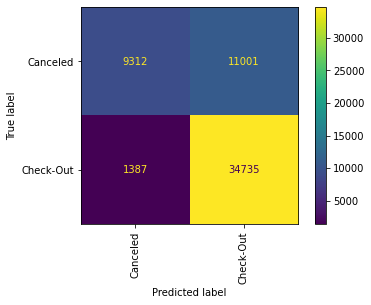

In [152]:
plot_confusion_matrix(model, X_val_encoded, y_val, values_format='.0f', xticks_rotation='vertical');

In [153]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

    Canceled       0.87      0.46      0.60     20313
   Check-Out       0.76      0.96      0.85     36122

    accuracy                           0.78     56435
   macro avg       0.81      0.71      0.72     56435
weighted avg       0.80      0.78      0.76     56435



In [154]:
y_pred_probab = model.predict_proba(X_val_encoded)

In [155]:
roc_auc_score(y_val,y_pred_probab[:,1])

0.810842994964474

In [156]:
accuracy_score(y_val,y_pred)

0.7804908301585896

In [157]:
probs = model.predict_proba(X_val_encoded)
probs

array([[8.0543756e-04, 9.9919456e-01],
       [3.5178661e-04, 9.9964821e-01],
       [1.4390767e-02, 9.8560923e-01],
       ...,
       [1.0970473e-02, 9.8902953e-01],
       [5.7681680e-02, 9.4231832e-01],
       [5.7681680e-02, 9.4231832e-01]], dtype=float32)

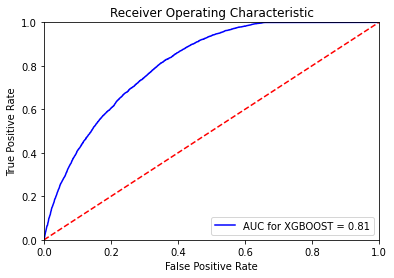

In [164]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = model.predict_proba(X_val_encoded)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_val, preds, pos_label='Check-Out')
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC for XGBOOST = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [159]:
#.81 AUC before feature selection based on feature importances